In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
import scipy

In [2]:
# project files

from utils.variables import pack, unpack
from utils.display import table, tabulate
from utils.files import download_sheet, save, load
from utils.hash import digest

from fit_options import fit_options
from game_model import game
from rp_model import compute_rp, make_precomputed_columns
from initial_guess import make_initial_guess

In [3]:
# stuff for display

from IPython.lib.pretty import pretty, pprint

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 120)

In [4]:
data = pd.read_pickle(fit_options.data_file)
data.describe()
data.head()

,Level,RP,MS lvl,ModelRP,Difference,Freq1,FreqL,Inv,Berry1,BerryL,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,BerryD,IngD,Dupes,Amnt,Ing2P,Help skill bonus,RP Multiplier
count,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.0,6534.000000,6534.000000,6534.000000,6534.000000
mean,10.853229,615.533364,1.502908,615.572189,0.038825,3944.459749,3791.715011,12.276094,28.061524,38.029691,109.003979,1.022954,0.988395,0.994858,1.000612,1.005326,0.207776,33.046729,55.868228,149.126645,1.0,0.078359,3.244873,0.987198,1.028745
std,7.311007,400.372168,0.995278,400.424290,0.985871,964.776439,1027.439788,3.398884,2.615911,8.230885,16.157611,0.305288,0.059258,0.044912,0.117631,0.118704,0.044995,36.934256,28.297937,61.165970,0.0,0.533277,21.530233,0.038346,0.071271
min,1.000000,245.000000,1.000000,245.060000,-11.980000,2200.000000,1489.118400,7.000000,24.000000,24.000000,90.000000,0.520000,0.890000,0.920000,0.800000,0.800000,0.130000,5.880000,25.000000,90.000000,1.0,0.000000,0.000000,0.790000,1.000000
25%,5.000000,356.000000,1.000000,356.392500,-0.290000,3200.000000,2934.360000,10.000000,26.000000,32.000000,98.000000,0.802500,1.000000,1.000000,1.000000,1.000000,0.180000,12.810000,35.000000,101.000000,1.0,0.000000,0.000000,1.000000,1.000000
50%,10.000000,470.000000,1.000000,470.100000,-0.010000,3900.000000,3773.000000,12.000000,28.000000,36.000000,103.000000,0.950000,1.000000,1.000000,1.000000,1.000000,0.200000,20.190000,46.000000,121.000000,1.0,0.000000,0.000000,1.000000,1.000000
75%,14.000000,724.000000,2.000000,723.817500,0.270000,4500.000000,4443.750000,14.000000,31.000000,42.000000,115.000000,1.220000,1.000000,1.000000,1.000000,1.000000,0.240000,43.980000,68.000000,202.000000,1.0,0.000000,0.000000,1.000000,1.000000
max,42.000000,3479.000000,6.000000,3479.540000,10.460000,6300.000000,6916.140000,23.000000,35.000000,83.000000,151.000000,2.410000,1.120000,1.080000,1.200000,1.200000,0.420000,413.950000,243.000000,511.000000,1.0,8.000000,342.000000,1.000000,1.440000


,Pokemon,Level,RP,Nature,MS lvl,Source,ModelRP,Difference,Nature2,ID,NatureP,NatureN,Freq1,FreqL,Type,Class,MSkill,Inv,Berry1,BerryL,Ing1,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,RPneutral,IDNeutral,BerryD,IngD,Dupes,DupeMatch,Sub Skill 1,Sub Skill 2,Ingredient 2,Amnt,Ing2P,Help skill bonus,RP Multiplier
0,Arbok,9.0,574.0,Naughty,1.0,Rate My Mon,574.42,0.42,Naughty,ArbokNaughty91,Speed of Help,Main Skill Chance,3700.0,3276.72,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,1.09,0.90,1.00,1.0,0.8,0.26,22.76,538.36,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
1,Arbok,8.0,531.0,Hardy,1.0,Questions help guides,530.70,-0.30,Neutral,ArbokNeutral81,-,-,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.0,1.0,0.26,22.76,531.00,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
2,Arbok,8.0,538.0,Quiet,1.0,Questions help guides,538.09,0.09,Quiet,ArbokQuiet81,Ingredient Finding,Exp Gains,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.2,1.0,0.26,22.76,530.61,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
3,Arcanine,5.0,958.0,Calm,3.0,,957.90,-0.10,Calm,ArcanineCalm53,Main Skill Chance,Speed of Help,2500.0,2728.00,Fire,Skills,Extra Helpful S,16.0,27.0,31,Fiery Herb,130.0,1.31,1.11,1.00,1.0,1.2,0.14,84.50,937.84,ArcanineNeutral53,31.0,130.0,1,True,,,,0.0,0.0,1.0,1.0
4,Arcanine,3.0,715.0,Lax,2.0,pokemon sleep general,714.77,-0.23,Lax,ArcanineLax32,Energy Recovery,Main Skill Chance,2500.0,2490.00,Fire,Skills,Extra Helpful S,16.0,27.0,29,Fiery Herb,130.0,1.44,1.00,1.08,1.0,0.8,0.14,61.21,750.21,ArcanineNeutral32,29.0,130.0,1,True,,,,0.0,0.0,1.0,1.0


In [5]:
# Make an initial guess
# Pack the dictionary into a 1-D vector.
# Also store information on how to unpack that vector

x0, unpack_info = pack(make_initial_guess())
computed = make_precomputed_columns(data)

In [6]:
# We compute the RP model in rp_model.py
# Here we create closure to glue the pieces together.

def RP(x):
    return compute_rp(x, data, computed, unpack_info)

# for the error analysis page,
# we'll compute the residual with exact rounding.

def residual(x):
    return data["RP"] - np.round(RP(x))


In [7]:
filename = fit_options.result_file(digest(data, x0))
opt = load(filename)
sol = unpack(opt.x, unpack_info)

opt

    message: `ftol` termination condition is satisfied.
    success: True
     status: 2
          x: [ 2.563e-01  2.544e-01 ...  2.212e-01  2.211e-01]
       cost: 895.6192997918448
       grad: [-1.035e-05 -1.478e-05 ...  0.000e+00  0.000e+00]
 optimality: 0.2867610949324444
       nfev: 39
       njev: 23

In [8]:
# What are the worst points?

df = data[["Pokemon","ID","Level","Class","Inv","MS lvl","NatureP","NatureN","Sub Skill 1","Sub Skill 2","RP"]].copy()

df["fit"] = np.round(RP(opt.x))
df["error"] = residual(opt.x)
df["error2"] = df["error"]**2

df = df.sort_values("error2", ascending = False)
df.head(100)

,Pokemon,ID,Level,Class,Inv,MS lvl,NatureP,NatureN,Sub Skill 1,Sub Skill 2,RP,fit,error,error2
456,Charizard,CharizardNeutral273Berry Finding SHelping Speed M,27.0,Ingredients,19.0,3.0,-,-,Berry Finding S,Helping Speed M,1528.0,1520.0,8.0,64.0
453,Charizard,CharizardRash273Helping bonusHelping Speed M,27.0,Ingredients,19.0,3.0,Ingredient Finding,Main Skill Chance,Helping bonus,Helping Speed M,1440.0,1432.0,8.0,64.0
2748,Togekiss,TogekissGentle103Skill Trigger M,10.0,Skills,16.0,3.0,Main Skill Chance,Energy Recovery,Skill Trigger M,,1282.0,1274.0,8.0,64.0
440,Charizard,CharizardNeutral273Inventory Up MHelping Speed M,27.0,Ingredients,19.0,3.0,-,-,Inventory Up M,Helping Speed M,1299.0,1292.0,7.0,49.0
2730,Sylveon,SylveonRelaxed102Helping bonus,10.0,Skills,15.0,2.0,Energy Recovery,EXP Gains,Helping bonus,,1023.0,1016.0,7.0,49.0
9,Absol,AbsolHasty171Helping Speed S,17.0,Ingredients,14.0,1.0,EXP Gains,Energy Recovery,Helping Speed S,,672.0,666.0,6.0,36.0
2878,Typhlosion,TyphlosionCareful273Berry Finding SHelping Spe...,27.0,Berries,23.0,3.0,Main Skill Chance,Ingredient Finding,Berry Finding S,Helping Speed M,1761.0,1755.0,6.0,36.0
458,Charizard,CharizardMild276Skill Level Up MHelping Speed M,27.0,Ingredients,19.0,6.0,Ingredient Finding,Energy Recovery,Skill Level Up M,Helping Speed M,1514.0,1508.0,6.0,36.0
364,Butterfree,ButterfreeNeutral103Sleep EXP Bonus,10.0,Berries,21.0,3.0,-,-,Sleep EXP Bonus,,843.0,837.0,6.0,36.0
335,Butterfree,ButterfreeImpish105Skill Level Up M,10.0,Berries,21.0,5.0,Energy Recovery,Ingredient Finding,Skill Level Up M,,901.0,895.0,6.0,36.0


In [9]:
# What are the worst points, level 1-9, Main Skill 1 ?
level_1_9 = df[(df["Level"]<10) ]
level_1_9_error =  level_1_9[ level_1_9["error2"] > 0.5 ]

level_1_9.describe()
level_1_9_error.describe()
level_1_9_error.head(100)

,Level,Inv,MS lvl,RP,fit,error,error2
count,3116.000000,3116.000000,3116.000000,3116.000000,3116.000000,3116.000000,3116.000000
mean,5.082157,10.519897,1.030488,371.310334,371.316110,-0.005777,0.047497
std,2.254937,2.213324,0.191391,75.662991,75.667757,0.217896,0.212733
min,1.000000,7.000000,1.000000,245.000000,245.000000,-1.000000,0.000000
25%,3.000000,9.000000,1.000000,321.000000,321.000000,0.000000,0.000000
50%,5.000000,10.000000,1.000000,354.000000,354.000000,0.000000,0.000000
75%,7.000000,12.000000,1.000000,403.000000,403.000000,0.000000,0.000000
max,9.000000,21.000000,3.000000,1089.000000,1088.000000,1.000000,1.000000


,Level,Inv,MS lvl,RP,fit,error,error2
count,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.0
mean,4.918919,11.155405,1.101351,394.250000,394.371622,-0.121622,1.0
std,2.467513,2.808425,0.364026,112.350997,112.393943,0.995947,0.0
min,1.000000,8.000000,1.000000,262.000000,263.000000,-1.000000,1.0
25%,3.000000,9.000000,1.000000,329.000000,330.000000,-1.000000,1.0
50%,5.000000,10.000000,1.000000,365.000000,366.000000,-1.000000,1.0
75%,7.000000,12.000000,1.000000,424.500000,425.500000,1.000000,1.0
max,9.000000,21.000000,3.000000,1089.000000,1088.000000,1.000000,1.0


,Pokemon,ID,Level,Class,Inv,MS lvl,NatureP,NatureN,Sub Skill 1,Sub Skill 2,RP,fit,error,error2
1052,Eevee,EeveeRash91,9.0,Skills,12.0,1.0,Ingredient Finding,Main Skill Chance,,,440.0,441.0,-1.0,1.0
555,Chikorita,ChikoritaSassy71,7.0,Berries,12.0,1.0,Main Skill Chance,EXP Gains,,,430.0,429.0,1.0,1.0
1202,Gastly,GastlyNaive61,6.0,Ingredients,10.0,1.0,EXP Gains,Main Skill Chance,,,330.0,331.0,-1.0,1.0
598,Cleffa,CleffaLonely71,7.0,Berries,10.0,1.0,Speed of Help,Energy Recovery,,,326.0,327.0,-1.0,1.0
2589,Spheal,SphealNeutral81,8.0,Berries,9.0,1.0,-,-,,,353.0,354.0,-1.0,1.0
2063,Pichu,PichuJolly11,1.0,Berries,10.0,1.0,EXP Gains,Ingredient Finding,,,274.0,273.0,1.0,1.0
2066,Pichu,PichuJolly41,4.0,Berries,10.0,1.0,EXP Gains,Ingredient Finding,,,299.0,298.0,1.0,1.0
1036,Eevee,EeveeNeutral91,9.0,Skills,12.0,1.0,-,-,,,475.0,476.0,-1.0,1.0
1031,Eevee,EeveeNeutral41,4.0,Skills,12.0,1.0,-,-,,,448.0,449.0,-1.0,1.0
2971,Totodile,TotodileHasty91,9.0,Berries,11.0,1.0,EXP Gains,Energy Recovery,,,395.0,396.0,-1.0,1.0


intercept,0.00163708
intercept_stderr,0.0113565
pvalue,0.712298
rvalue,-0.00456298
slope,-0.000320055
stderr,0.000867856


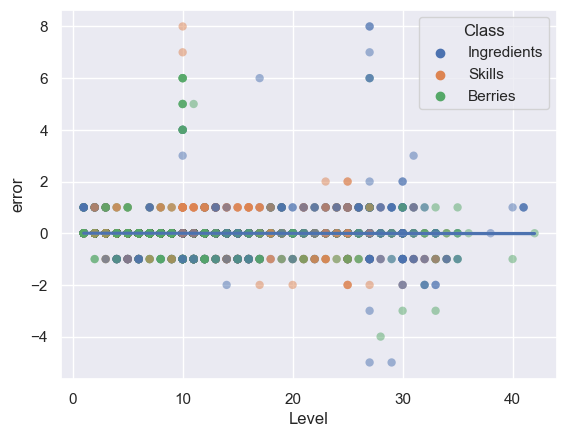

In [10]:
# Plot error vs level

err = df[["Level","error","Class"]]
palette = sns.color_palette(n_colors=3)

_ = sns.scatterplot(data=err, x="Level", y="error", hue="Class", alpha=0.5, linewidth=0, palette=palette)
_ = sns.regplot(data=err, x="Level", y="error", scatter=False)

# What is the slope?
linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

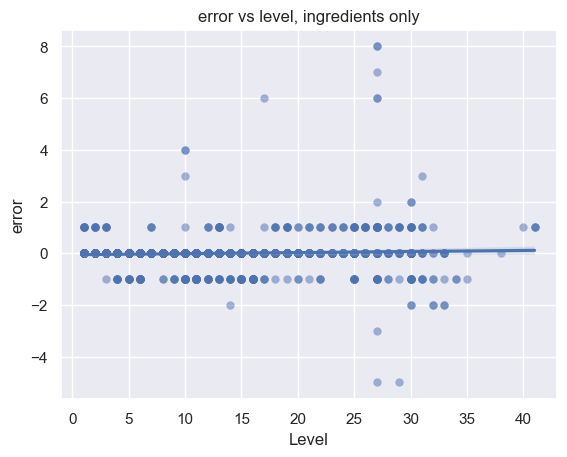

In [11]:
err2 = err[ err["Class"]=="Ingredients" ]
p = sns.scatterplot(data=err2, x="Level", y="error", alpha=0.5, linewidth=0, color=palette[0])
_ = sns.regplot(data=err2, x="Level", y="error", scatter=False)
_ = p.set(title='error vs level, ingredients only')


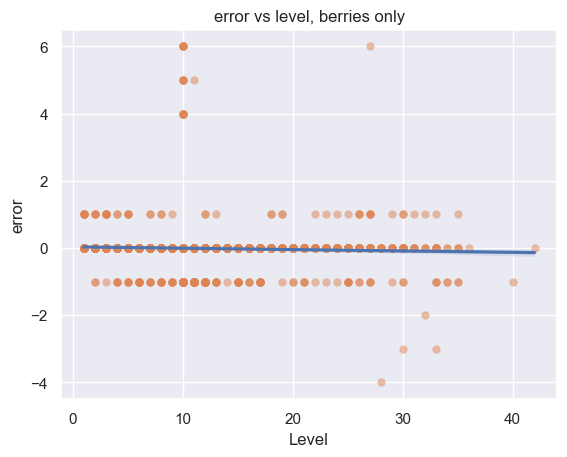

In [12]:
err2 = err[ err["Class"]=="Berries" ]
p = sns.scatterplot(data=err2, x="Level", y="error", alpha=0.5, linewidth=0, color=palette[1])
_ = sns.regplot(data=err2, x="Level", y="error", scatter=False)
_ = p.set(title='error vs level, berries only')

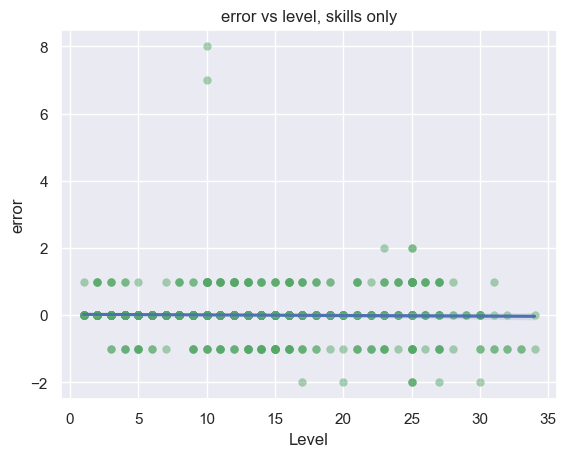

In [13]:
err2 = err[ err["Class"]=="Skills" ]

p = sns.scatterplot(data=err2, x="Level", y="error", alpha=0.5, linewidth=0, color=palette[2])
_ = sns.regplot(data=err2, x="Level", y="error", scatter=False)
_ = p.set(title='error vs level, skills only')


intercept,-0.0111325
intercept_stderr,0.00833743
pvalue,0.914109
rvalue,-0.00157216
slope,-9.48516e-05
stderr,0.000879376


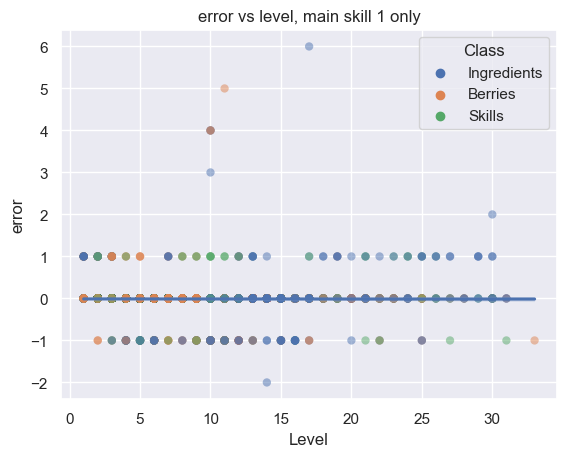

In [14]:
# Plot error vs level - focus on main skill 1

err = df[["Level","error","Class"]].loc[df["MS lvl"]==1]

p = sns.scatterplot(data=err, x="Level", y="error", hue="Class", alpha=0.5, linewidth=0)
_ = sns.regplot(data=err, x="Level", y="error", scatter=False)

_ = p.set(title='error vs level, main skill 1 only')

# What is the slope ?
linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

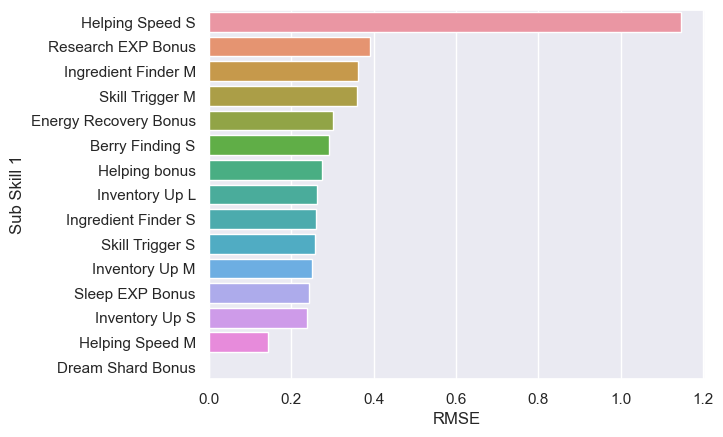

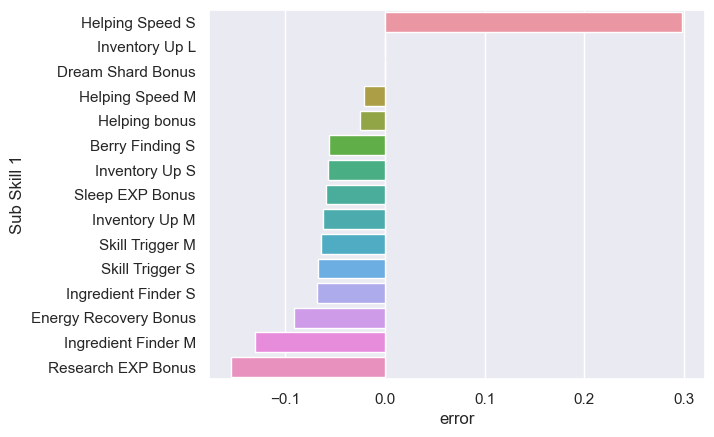

In [15]:
# Let's see what happens at level 10 and main skill 1

subskill_err = ( df[["Level", "Sub Skill 1", "error", "error2"]].loc[ (df["Level"]==10) & (df["MS lvl"]==1) ]
                .groupby("Sub Skill 1")
                .mean()
                .sort_values("error2", ascending = False)
                .reset_index() )

subskill_err["RMSE"] = np.sqrt(subskill_err["error2"])

_ = plt.figure()
_ = sns.barplot(data=subskill_err, y="Sub Skill 1", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=subskill_err.sort_values("error", ascending = False), y="Sub Skill 1", x="error")


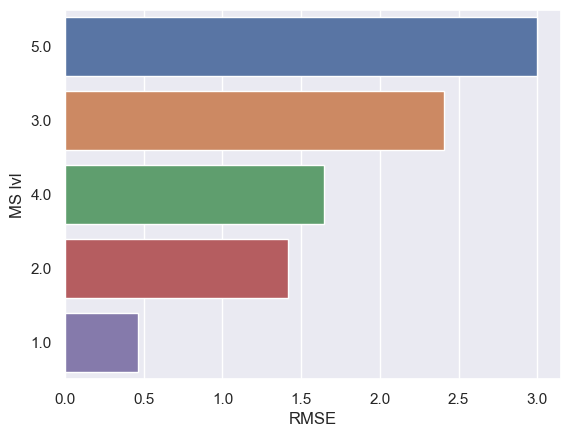

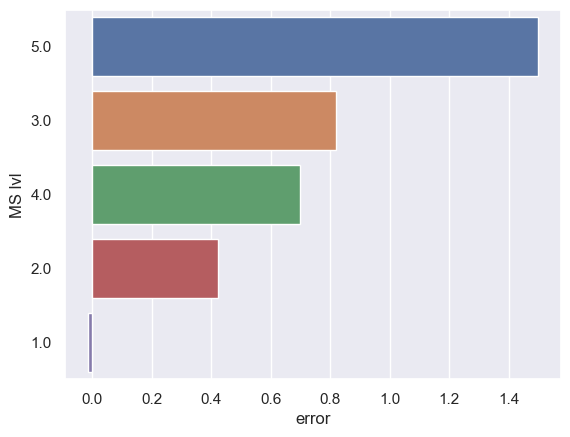

In [22]:
mslvl_err = ( df[["Level", "MS lvl", "error", "error2"]][df["Level"]==10]
                .groupby("MS lvl")
                .mean()
                .sort_values("error2", ascending = False)
                .reset_index() )

mslvl_err["RMSE"] = np.sqrt(mslvl_err["error2"])
mslvl_err["MS lvl"] = mslvl_err["MS lvl"].astype(str)

_ = plt.figure()
_ = sns.barplot(data=mslvl_err, y="MS lvl", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=mslvl_err.sort_values("error", ascending = False), y="MS lvl", x="error")


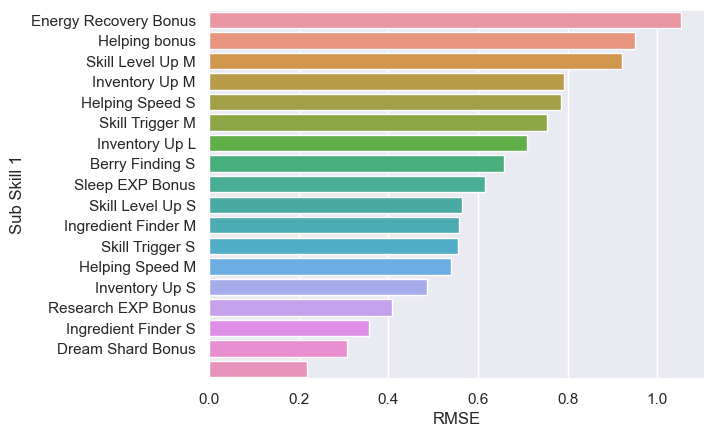

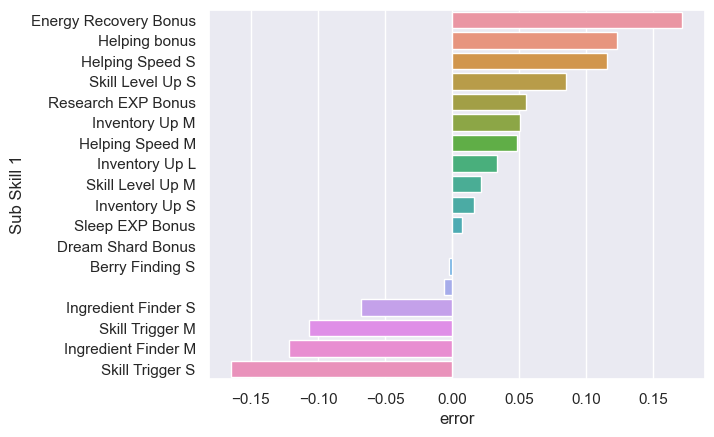

In [23]:
# Do we have more error in some skills ?

errorbyskill1 = (df[["Sub Skill 1","error","error2"]]
                .groupby("Sub Skill 1")
                .mean()
                .sort_values("error2", ascending = False)
                #.rename(columns={"error":"avg abs error"})
                .reset_index() )

errorbyskill1["RMSE"] = np.sqrt(errorbyskill1["error2"])
    
_ = plt.figure()
_ = sns.barplot(data=errorbyskill1, y="Sub Skill 1", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=errorbyskill1.sort_values("error", ascending = False), y="Sub Skill 1", x="error")

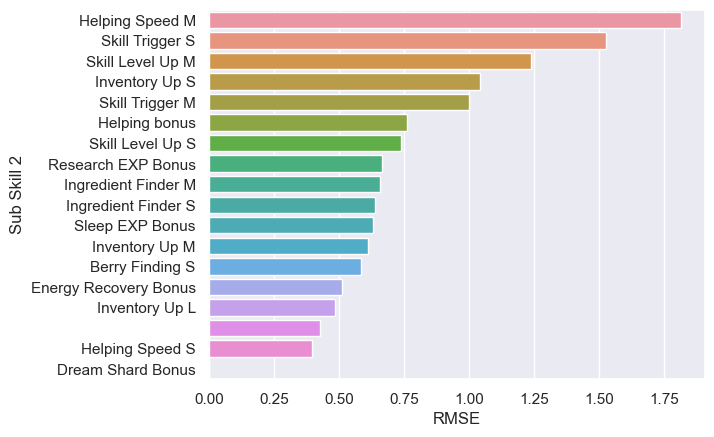

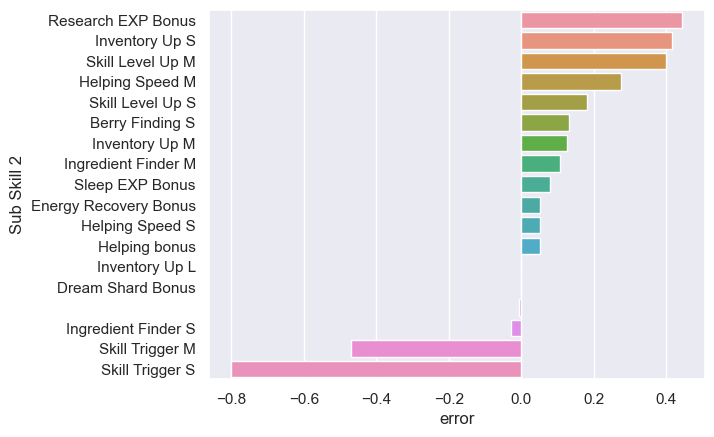

In [24]:
errorbyskill2 = (df[["Sub Skill 2","error","error2"]]
                .groupby("Sub Skill 2")
                .mean()
                .sort_values("error2", ascending = False)
                #.rename(columns={"error":"avg abs error"})
                .reset_index() )

errorbyskill2["RMSE"] = np.sqrt(errorbyskill2["error2"])
    
_ = plt.figure()
_ = sns.barplot(data=errorbyskill2, y="Sub Skill 2", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=errorbyskill2.sort_values("error", ascending = False), y="Sub Skill 2", x="error")